In [2]:
import os, keras, cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorboard
from keras import layers, losses, callbacks, activations, regularizers, metrics, applications, optimizers

In [3]:
# point to the data point set the batch and image size
data = os.path.join(os.getcwd(), 'dataset')
BATCH_SIZE = 10
IMG_SIZE = (160, 160)

In [4]:
# split data to train and val
train_d, val_d = keras.utils.image_dataset_from_directory(data,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          validation_split=0.3,
                                                          subset='both',
                                                          seed=42)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Using 12000 files for validation.


['Negative', 'Positive']


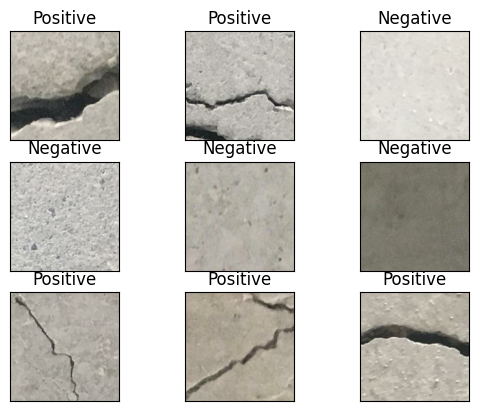

In [5]:
# watch our data
class_names = train_d.class_names
print(class_names)
batch_1 = train_d.take(1)
for feature, label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

In [ ]:
# augment the data
data_aug = keras.Sequential()
# randomly flips the image horizontally or vertically this is to help the model learn invariance to left-right orientations.
data_aug.add(layers.RandomFlip())
# randomly rotates the image by up to ±20% of 180 degrees helps the model be more robust to different angles.
data_aug.add(layers.RandomRotation(factor=0.2))

In [7]:
# use mobilenet v2 as pretrain model
preprocess_input = applications.mobilenet_v2.preprocess_input

In [8]:
# apply transfer learning
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# freeze the feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# construct classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

In [10]:
# use functional api to connect all layers
inputs = keras.Input(shape=IMG_SHAPE)
# augmentation layers
x = data_aug(inputs)
# preprocessing layer
x = preprocess_input(x)
# feature extractor
x = base_model(x)
# classifier
x = global_avg(x)
outputs = output_layer(x)
# create model
model = keras.Model(inputs = inputs, outputs= outputs)
model.summary()
keras.utils.plot_model(model=model)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [11]:
# compile model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [12]:
# train model
es = callbacks.EarlyStopping(patience=2, verbose=1)
log_path = f'logs/'
ts = keras.callbacks.TensorBoard(log_dir=log_path)
epochs = 10
history_first = model.fit(train_d, validation_data=val_d, epochs=epochs, callbacks=[es,ts])

Epoch 1/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 334s 116ms/step - accuracy: 0.9750 - loss: 0.0827 - val_accuracy: 0.9968 - val_loss: 0.0107
Epoch 2/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 323s 115ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9976 - val_loss: 0.0078
Epoch 3/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 319s 114ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9978 - val_loss: 0.0074
Epoch 4/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 338s 121ms/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.9983 - val_loss: 0.0063
Epoch 5/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 340s 121ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.9981 - val_loss: 0.0065
Epoch 6/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 275s 98ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9983 - val_loss: 0.0058
Epoch 7/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 231s 83ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9983 - val_loss: 0.0055
Epoch 8/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 252s 90ms/step - accur

In [13]:
# 2nd stage transfer learning
# unfreeze model
base_model.trainable = True
# free earlier model of the base model
finetune_at = 100
for layer in base_model.layers[:finetune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [14]:
rmsprop = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rmsprop, loss=loss, metrics=['accuracy'])

In [15]:
# train the second part
second_epochs = 10
total_epochs = epochs + second_epochs
starting_epoch = history_first.epoch[-1] + 1
history_second = model.fit(train_d, validation_data=val_d, epochs=total_epochs, batch_size=BATCH_SIZE, initial_epoch=starting_epoch, callbacks=[es,ts])

Epoch 10/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 301s 105ms/step - accuracy: 0.9527 - loss: 0.1443 - val_accuracy: 0.9981 - val_loss: 0.0062
Epoch 11/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 277s 99ms/step - accuracy: 0.9933 - loss: 0.0232 - val_accuracy: 0.9987 - val_loss: 0.0046
Epoch 12/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 283s 101ms/step - accuracy: 0.9968 - loss: 0.0103 - val_accuracy: 0.9986 - val_loss: 0.0040
Epoch 13/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 275s 98ms/step - accuracy: 0.9973 - loss: 0.0124 - val_accuracy: 0.9987 - val_loss: 0.0037
Epoch 14/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 279s 99ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9987 - val_loss: 0.0035
Epoch 15/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 282s 101ms/step - accuracy: 0.9980 - loss: 0.0087 - val_accuracy: 0.9987 - val_loss: 0.0034
Epoch 16/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 287s 102ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 17/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 311s 111ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
['Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive']


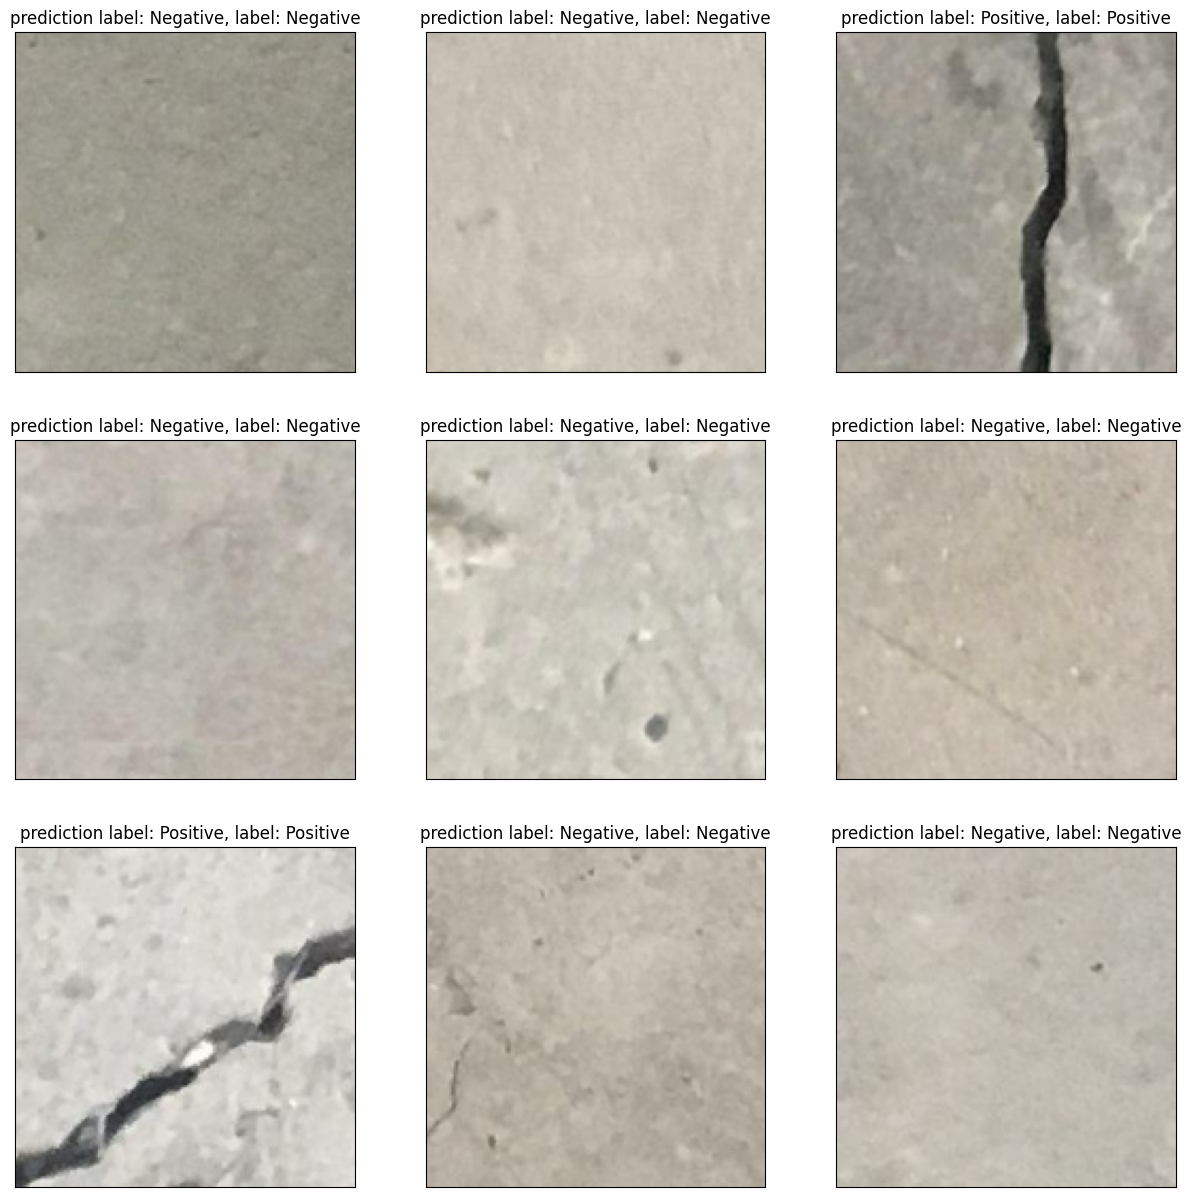

In [16]:
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [17]:
model.save('model/model2.keras')

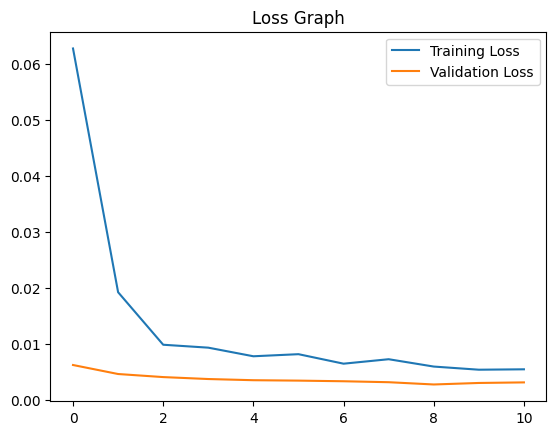

In [18]:
# Plot the graph of loss and accuracy
plt.plot(history_second.history['loss'])
plt.plot(history_second.history['val_loss'])
plt.title("Loss Graph")
plt.legend(["Training Loss","Validation Loss"])
plt.show()